In [1]:
import pickle
import pandas as pd
import seaborn as sns
from sortedcollections import SortedDict

# Building an INDRA interactome

Attempting to build a high quality INDRA interactome for network reconstruction tasks

## Loading Statements

I'm trying a new technique where successive transformations of a pandas dictionary are stored in a SortedDict

In [2]:
data = SortedDict()

In [3]:
data['dump'] = pd.read_pickle('../input/refresh_db_dataframe_20190702.pkl')

We then filter to only statements where both agents have either a FamPlex or HGNC grounding

In [4]:
data['dump'].head()

,agA_ns,agA_id,agA_name,agB_ns,agB_id,agB_name,stmt_type,evidence_count,hash
0,CHEBI,33390,curium atom,CHEBI,73393,Ala-Pro,Activation,2,34383272364686263
1,HGNC,23115,EAF2,HGNC,9949,RECQL4,Complex,8,-15857139029803505
2,HGNC,9949,RECQL4,HGNC,23115,EAF2,Complex,8,-15857139029803505
3,HGNC,1504,CASP3,HGNC,1504,CASP3,Activation,1,-13935936771122175
4,FPLX,Histone,Histone,HGNC,7838,NKX3-1,Complex,1,-13189437166943042


In [5]:
data['gene_stmts'] = data['dump'][((data['dump'].agA_ns == 'HGNC') | 
                                   (data['dump'].agA_ns == 'FPLX')) &
                                   ((data['dump'].agB_ns == 'HGNC') | 
                                    (data['dump'].agB_ns == 'FPLX'))].copy()

The belief scores are included in a separate pickle file

In [6]:
with open('../input/belief_dict_refresh_db_20190701.pkl', 'rb') as f:
    belief = pickle.load(f)

This dictionary is keyed by hash. Let's add them as a column to gene_stmts_df

In [7]:
data['gene_stmts']['belief'] = data['gene_stmts'].hash.apply(lambda x: belief[x])

We see below that there is a large peak of statements with minimal belief. Of 3,077,741 total statements with both agents grounded to human genes or gene families, only 1,473,180 have belief greater than 0.65. We filter out the low belief statements

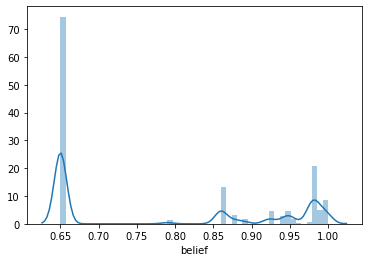

In [8]:
sns.distplot(data['gene_stmts'].belief)

In [9]:
data['filter_belief'] = data['gene_stmts'][data['gene_stmts'].belief > 0.65].copy()

In [10]:
(len(data['filter_belief']), len(data['gene_stmts']))

(1473180, 3077741)

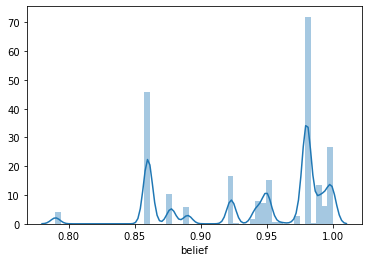

In [11]:
sns.distplot(data['filter_belief'].belief)

Below we see the statements within our network. All of the different post-translational modifications as well as complexes should be included when building networks for running the temporal pathway synthesizer. One of its goals is to determine regulators of phosphorylation amoung different interactions beyond direct phosphorylation and dephosphorylation.
Conversion statements are problematic in this context and will be filtered out.

In [13]:
data['filter_belief'].stmt_type.unique()

array(['Complex', 'DecreaseAmount', 'Phosphorylation', 'Activation',
       'IncreaseAmount', 'Inhibition', 'Acetylation', 'Dephosphorylation',
       'Glycosylation', 'Ubiquitination', 'Deacetylation', 'Sumoylation',
       'Methylation', 'Deubiquitination', 'Demethylation',
       'Deglycosylation', 'Dehydroxylation', 'Gap', 'Gef',
       'Hydroxylation', 'Palmitoylation', 'Desumoylation',
       'GtpActivation', 'Ribosylation', 'Depalmitoylation', 'Conversion',
       'Myristoylation', 'Farnesylation', 'Deribosylation',
       'Geranylgeranylation'], dtype=object)

In [15]:
data['relevant_type'] = data['filter_belief'][(data['filter_belief'].stmt_type != 
                                               'Conversion')].copy()

In [16]:
data['relevant_type'].head()

,agA_ns,agA_id,agA_name,agB_ns,agB_id,agB_name,stmt_type,evidence_count,hash,belief
1,HGNC,23115,EAF2,HGNC,9949,RECQL4,Complex,8,-15857139029803505,0.992898
2,HGNC,9949,RECQL4,HGNC,23115,EAF2,Complex,8,-15857139029803505,0.992898
10,HGNC,9232,PPARA,HGNC,3576,FADS3,DecreaseAmount,1,-32896660950224390,0.790000
26,HGNC,3052,DSP,HGNC,8823,PECAM1,Complex,2,14830522647946258,0.997800
27,HGNC,8823,PECAM1,HGNC,3052,DSP,Complex,2,14830522647946258,0.997800


We now have to do some flattening. But first lets remove self edges since they have no role in steiner analysis

In [17]:
data['no_self'] = data['relevant_type'][(data['relevant_type'].agA_name !=
                                         data['relevant_type'].agB_name)].copy()

We only want one edge between any pair of agents. If there are conflicting directions between two agents, we place an undirected edge between these agents. If there is only one direction along with undirected complexes, assign the edge the given direction.

In [18]:
df = data['no_self'].copy()

Let's combine name space and name into a single identifier so we an distinguish between HGNC entries and FPLX entries

In [19]:
df['agent1'] = df.apply(lambda row: f'{row.agA_ns}:{row.agA_name}', axis=1)

In [20]:
df['agent2'] = df.apply(lambda row: f'{row.agB_ns}:{row.agB_name}', axis=1)

We than drop all but the relevant columns

In [21]:
df = df[['agent1', 'agent2', 'stmt_type', 'belief']]

We flatten statements with the same agents in the same order by taking the max of the belief scores and concatenating statement types into a list

In [22]:
groups = df.groupby(['agent1', 'agent2'], as_index=False)

In [23]:
flattened = groups.agg({'stmt_type': list, 'belief': max})

We create a new column that contains the agent strings sorted and concatenated, so we can check for pairs of statements with the same agents but in different directions

In [24]:
flattened['agents_sorted'] = flattened.apply(lambda row: '#'.join(sorted([row.agent1,
                                                                          row.agent2])),
                                            axis=1)

We also have a column for the agents concatenated in their original order

In [25]:
flattened['agents'] = flattened.apply(lambda row: '#'.join(tuple([row.agent1,
                                                                 row.agent2])),
                                            axis=1)

and then drop the columns agent1 and agent2 since they are no longer needed

In [26]:
flattened = flattened.drop(['agent1', 'agent2'], axis=1)

Complexes are undirected. All other statements are directed. If there is at least one directed statement for a given pair of agents in a given order we mark this edge as directed

In [27]:
flattened['pre_direction'] = flattened.stmt_type.apply(lambda x: 'U' if x == ['Complex']
                                                   else 'D')

This is only the pre_direction, since we will make an edge undirected if there are directed edges pointing in each direction. To carry this out we first group by the column agents_sorted

In [28]:
groups = flattened.groupby('agents_sorted', as_index=False)

We then aggregate by concatenating predirection, stmt_type and agents into lists, and taking the max of belief

In [37]:
df = groups.agg({'pre_direction': list, 'stmt_type': list,
                 'agents': lambda x: x.iloc[0], 'belief': max})

and here is where only edges with a directed statement in one of two directions become directed, with others being undirected

In [38]:
df['direction'] = df.pre_direction.apply(lambda x: 'D' if x.count('D') == 1 else 'U')

Let's recreate separate columns for agent1 and agent2

In [45]:
df[['agent1', 'agent2']] = df.agents.apply(lambda x: pd.Series(x.split('#')))

We extract the relevant columns into an interactome which is saved for later use

In [47]:
interactome = df[['agent1', 'agent2', 'belief', 'direction']]

In [50]:
interactome.to_csv('../input/indra_interactome3.tsv', sep='\t', header=False, index=False)

In [51]:
len(interactome)

631160